In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, BertModel,
                          AutoConfig, AutoModel)
import gc
import codecs

In [3]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [27]:
from shopee_utils import *

In [61]:
OUTPUT_CLASSES=11014
RECIPROCAL_THRESH = .94

In [6]:
TRIAL_RUN=False

In [7]:
def efficientnet_b0(pretrained): return timm.create_model('efficientnet_b0', pretrained=pretrained)
def efficientnet_b1(pretrained): return timm.create_model('efficientnet_b1', pretrained=pretrained)
def efficientnet_b2(pretrained): return timm.create_model('efficientnet_b2', pretrained=pretrained)

In [8]:
class conf():
    bs = 64
    arch = efficientnet_b0
    arcface_m=.4
    arcface_s=30

In [9]:
text_model_name='bert_large_state0.pth'
img_model_name='b0_788.pth'

PATH = Path('../input/shopee-product-matching')
models_path = Path('../input/shopee-models')
BERT_PATH = '../input/bertlarge-config'

if not PATH.is_dir():
    PATH = Path('/home/slex/data/shopee')
    models_path = Path('./models')
    BERT_PATH = './indobert-large-p2'
image_model_file = models_path / img_model_name
text_model_file = models_path / text_model_name

In [10]:

train_df = pd.read_csv(PATH/'train.csv')
train_df = add_splits(train_df)

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


## TEXT

In [11]:
class EmbsModel(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
    def forward(self, x):
        output = self.bert_model(*x)
        return output.last_hidden_state[:,0,:]

In [12]:
class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
        
        
    def encodes(self, row):
        text = row.title
        text=(codecs.decode(text, 'unicode_escape'))
        encodings = self.tokenizer(text, padding = 'max_length', max_length=50, truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask', 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

In [13]:
tfm = TitleTransform()

data_block = DataBlock(
    blocks = (TransformBlock(type_tfms=tfm), 
              CategoryBlock(vocab=train_df.label_group.to_list())),
    splitter=ColSplitter(),
    get_y=ColReader('label_group'),
    )
text_dls = data_block.dataloaders(train_df, bs=256)


In [14]:
def generate_text_embs(dl):
    model = AutoModel.from_config(AutoConfig.from_pretrained(BERT_PATH))
    state = torch.load(text_model_file)
    model.load_state_dict(state)
    model = EmbsModel(model).cuda().eval()
    embs, ys = embs_from_model(model, dl)
    return embs.half(), ys

def generate_text_pairs(dl):
    embs, ys = generate_text_embs(dl)
    target_matrix = ys[:,None]==ys[None,:]
    groups = [torch.where(t)[0].tolist() for t in target_matrix]
    dists, inds = get_nearest(embs, do_chunk(embs))
    pairs = sorted_pairs(dists, inds)[:len(embs)*10]
    return pairs, groups

In [15]:
# pairs, groups = generate_text_pairs(text_dls.valid)
# _=build_from_pairs(pairs, groups, True)

## IMAGE


In [16]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(in_features, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    


class ResnetArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = create_body(conf.arch, cut=-2, pretrained=False)
        nf = num_features_model(nn.Sequential(*self.body.children()))
        self.after_conv=nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(nf*2),
            nn.Dropout(.25))
        self.classifier = ArcFaceClassifier(nf*2, OUTPUT_CLASSES)
        self.outputEmbs = False
    def forward(self, x):
        x = self.body(x)
        embeddings = self.after_conv(x)
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)

In [17]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

In [18]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls_image = data_block.dataloaders(train_df, bs=conf.bs)


In [19]:
def generate_image_embs(dl):
    model = ResnetArcFace()
    state = torch.load(image_model_file)
    model.load_state_dict(state['model'])
    model = model.cuda().eval()
    model.outputEmbs = True
    embs, ys = embs_from_model(model, dl)
    return embs.half(), ys

def generate_image_pairs(dl):
    embs, ys = generate_image_embs(dl)
    target_matrix = ys[:,None]==ys[None,:]
    groups = [torch.where(t)[0].tolist() for t in target_matrix]
    dists, inds = get_nearest(embs, do_chunk(embs))
    pairs = sorted_pairs(dists, inds)[:len(embs)*10]
    return pairs, groups

In [20]:
# pairs, groups = generate_image_pairs(dls_image.valid)
# _=build_from_pairs(pairs, groups, True)

## Distances for combined top-K indices

In [21]:
def combined_dists(img_embs, text_embs):
    _, img_inds = get_nearest(img_embs, do_chunk(img_embs))

    _, text_inds = get_nearest(text_embs, do_chunk(text_embs))

    combined_inds = torch.cat([img_inds, text_inds],dim=1)
    img_dists = get_dist_for_inds(img_embs, combined_inds)

    text_dists = get_dist_for_inds(text_embs, combined_inds)
    return combined_inds, img_dists, text_dists

## Check on validation set

In [24]:
TRIAL_RUN=True

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.881 at 6.158493995666504 pairs or 0.722 threshold


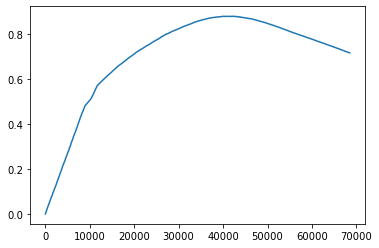

In [25]:
if TRIAL_RUN:
    img_embs,ys = generate_image_embs(dls_image.valid)

    text_embs,ys = generate_text_embs(text_dls.valid)

    target_matrix = ys[:,None]==ys[None,:]
    targets = [torch.where(t)[0].tolist() for t in target_matrix]

    combined_inds, img_dists, text_dists = combined_dists(img_embs, text_embs)
    
    # --- use max
#     max_dists = torch.max(img_dists, text_dists)
#     triplets = sorted_pairs(max_dists, combined_inds)[:len(img_embs)*10]
#     _=build_from_pairs(triplets, targets)
    # --- use and
    and_dists = img_dists+text_dists - img_dists*text_dists
    triplets = sorted_pairs(and_dists, combined_inds)[:len(img_embs)*10]
    _=build_from_pairs(triplets, targets)
    # --- used scaled and
#     img_params={'min_val': 0.26708984375, 'a': -3.8065830142124857, 'b': 4.92549411772561, 'c': 1.031201433949806}
#     text_params={'min_val': 0.68115234375, 'a': -785.4151875846186, 'b': 9.68828642715568, 'c': 1.0604532834375875}
#     img_scaler = functools.partial(do_scale, **img_params)
#     text_scaler = functools.partial(do_scale, **text_params)

#     scaled_img = img_scaler(img_dists)
#     scaled_txt = text_scaler(text_dists)
#     and_scaled = scaled_txt+scaled_img - scaled_txt*scaled_img
#     triplets = sorted_pairs(and_scaled, combined_inds)[:len(img_embs)*10]
#     _=build_from_pairs(triplets, targets)

## Shave

0.8902421122479399


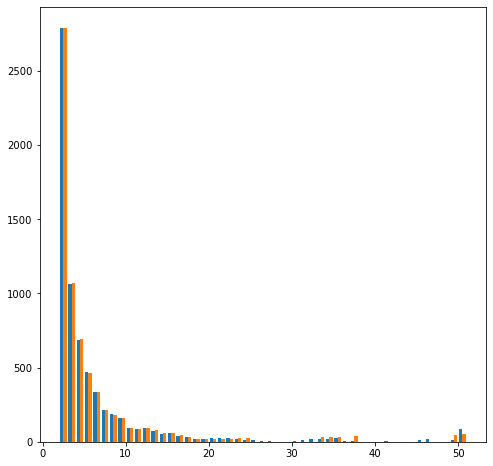

In [26]:
if TRIAL_RUN:
    groups =group_and_shave(and_dists, combined_inds, train_df)
    groups_lens = [len(g)for g in groups]
    targets_lens = [len(g) for g in targets]
    plt.figure(figsize=(8,8)) 
    plt.hist((groups_lens,targets_lens) ,bins=list(range(2,52)))
    print(score_all_groups(groups, targets))

## Rerank

In [34]:
if TRIAL_RUN:
    D = gen_sim_and(img_embs, text_embs)

    r_dists, r_ind=top_reciprocal(D, .83, False, False)
    groups = group_and_shave(r_dists, r_ind, train_df)
    score_all_groups(groups, targets)

0.881 at 6.158493995666504 pairs or 0.722 threshold
0.887 at 6.005399703979492 pairs or 0.721 threshold


0.8872379855498841

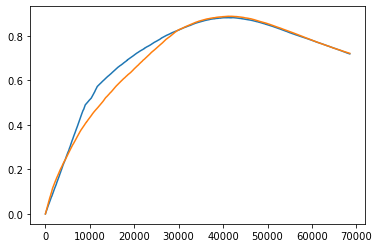

In [45]:
if TRIAL_RUN:
    score_distances(D, targets, True)
    score_distances(all_reciprocal(D,.83),targets, True)

In [51]:
# def find_best_tresh(D, targets,scaled=False, include_x=False):
#     best_t,best_score =0,0
#     for t in tqdm(np.linspace(.7,1,num=20)):
#         RD = all_reciprocal(D,t,scaled, include_x)
#         sc = score_distances(RD, targets)
#         if sc > best_score: best_t, best_score = t, sc
#     return best_t

# find_best_tresh(D,targets,False,False)
# find_best_tresh(D,targets,False,True)
# find_best_tresh(D,targets,True,False)
# find_best_tresh(D,targets,True,True)

0.887 at 6.192498683929443 pairs or 0.733 threshold
0.887 at 6.282253265380859 pairs or 0.721 threshold
0.888 at 6.019702434539795 pairs or 0.722 threshold
0.887 at 6.035610198974609 pairs or 0.721 threshold


0.8873150047704503

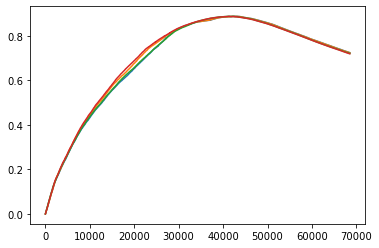

In [53]:
# score_distances(all_reciprocal(D,.826,False,False),targets, True)
# score_distances(all_reciprocal(D,.826,False,True),targets, True)
# score_distances(all_reciprocal(D,.842,True,False),targets, True)
# score_distances(all_reciprocal(D,.842,True,True),targets, True)

## Run on the test set

In [54]:
test_df = pd.read_csv(PATH/'test.csv')

In [55]:
if TRIAL_RUN:
    fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title', 'label_group']].copy()
    fake_test_df = pd.concat([fake_test_df, fake_test_df])
    fake_test_df = add_target_groups(fake_test_df)
    test_df = fake_test_df

In [56]:
text_embs,_ = generate_text_embs(text_dls.test_dl(test_df))

  0%|          | 0/268 [00:00<?, ?it/s]

In [57]:
gc.collect()
torch.cuda.empty_cache()

In [58]:
test_dl = dls_image.test_dl(test_df)
img_embs,_ = generate_image_embs(test_dl)

  0%|          | 0/1071 [00:00<?, ?it/s]

In [59]:
gc.collect()
torch.cuda.empty_cache()

In [62]:
D =gen_sim_and(img_embs, text_embs)

In [67]:
r_dists, r_ind=top_reciprocal(D, RECIPROCAL_THRESH, False, False)
groups = group_and_shave(r_dists, r_ind, train_df)

In [68]:
if 'target' in test_df.columns.to_list():
    print(score_all_groups(groups, test_df.target.to_list()))

0.675357298300006


In [65]:
matches = [' '.join(test_df.iloc[g].posting_id.to_list()) for g in groups]
test_df['matches'] = matches

test_df[['posting_id','matches']].to_csv('submission.csv',index=False)

In [66]:
pd.read_csv('submission.csv').head()

,posting_id,matches
0,train_129225211,train_2278313361 train_129225211 train_129225211 train_2278313361
1,train_3386243561,train_1974987067 train_1974987067
2,train_2288590299,train_3803689425 train_2288590299
3,train_2406599165,train_1744956981 train_1744956981
4,train_3369186413,train_3369186413 train_921438619 train_3369186413 train_921438619
